In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

In [3]:
import timeit

def create_df():
    header = ['id', 'tweet', 'target']

    df = pd.read_csv('sentiment_tweets3.csv', names=header, header=0, encoding='latin-1')

    df = df.drop('id', axis=1)

    return df

timeit.Timer(create_df).timeit(number=1) * 1000

14.88290002453141

In [4]:
header = ['id', 'tweet', 'target']

tweet_df = pd.read_csv('sentiment_tweets3.csv', names=header, header=0, encoding='latin-1')
suicide_df = pd.read_csv('Suicide_Detection.csv', names=header, header=0, encoding='latin-1')
tweet_df = tweet_df.drop('id', axis=1)
suicide_df = suicide_df.drop('id', axis=1)
suicide_df['target'] = suicide_df['target'].map({'suicide': 1, 'non-suicide': 0})

df = pd.concat([tweet_df, suicide_df], ignore_index=True, sort=False)

df

,tweet,target
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
242383,If you don't like rock then your not going to ...,0
242384,You how you can tell i have so many friends an...,0
242385,pee probably tastes like salty teaðð¦â¼ï...,0
242386,The usual stuff you find hereI'm not posting t...,1


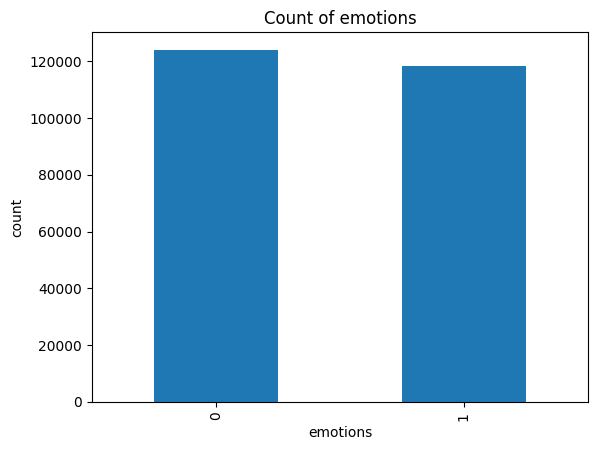

In [5]:
df['target'].value_counts().sort_index().plot(kind='bar', title='Count of emotions')
plt.xlabel("emotions")
plt.ylabel("count")

plt.show()

In [6]:
example = df['tweet'][2].lower()
print(example)

@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zogfqvh2me8 


In [7]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

In [8]:
raw_token = word_tokenize(example)
raw_token

['@',
 'comeagainjen',
 'http',
 ':',
 '//twitpic.com/2y2lx',
 '-',
 'http',
 ':',
 '//www.youtube.com/watch',
 '?',
 'v=zogfqvh2me8']

In [9]:
import string
import re
stopwords = set(nltk.corpus.stopwords.words('english'))

# token = [WordNetLemmatizer().lemmatize(w) for w in stopwords_removed_token]

def clean_words(words):
    table = str.maketrans('', '', string.punctuation)
    splitted_words = words.split()

    lower_split = [w for w in splitted_words if "@" not in w]
    lower_split = [w for w in lower_split if "#" not in w]
    lower_split = [w for w in lower_split if "http" not in w]
    
    lower_split = [w.strip() for w in lower_split]
    lower_split = [w for w in lower_split if not w.isdigit()]
    lower_split = [w for w in lower_split if w.isalpha()]

    lower_split = [w.translate(table) for w in lower_split]

    stopwords_removed_token = [w for w in lower_split if not w in stopwords]
    token = [PorterStemmer().stem(w) for w in stopwords_removed_token]

    token = " ".join(str(x) for x in token)
    return token

df['tweet'] = df['tweet'].apply(lambda x: clean_words(x))

df.head(10)

,tweet,target
0,real good missssssssss,0
1,read manga,0
2,,0
3,need send account i even refer those support,0
4,add me on,0
5,good time tonight though,0
6,someon alreadi fiber home mean least regular,0
7,possibl nice,0
8,nite twittervil workout,0
9,sweet dream,0


In [10]:
x_data = df['tweet']
y_data = df['target']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=100)


In [11]:
from catboost import CatBoostClassifier
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
# Create the CatBoostClassifier
model = CatBoostClassifier(verbose=0, n_estimators=100)

In [13]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [14]:
model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6)
model.fit(x_train, y_train, verbose=0)

In [15]:
# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(model, x_train, y_train, cv=6)

0:	learn: 0.6315027	total: 137ms	remaining: 13.5s
1:	learn: 0.5840562	total: 287ms	remaining: 14.1s
2:	learn: 0.5491419	total: 428ms	remaining: 13.9s
3:	learn: 0.5213672	total: 564ms	remaining: 13.5s
4:	learn: 0.4986615	total: 695ms	remaining: 13.2s
5:	learn: 0.4824406	total: 828ms	remaining: 13s
6:	learn: 0.4668437	total: 970ms	remaining: 12.9s
7:	learn: 0.4547459	total: 1.1s	remaining: 12.7s
8:	learn: 0.4445824	total: 1.25s	remaining: 12.6s
9:	learn: 0.4372100	total: 1.38s	remaining: 12.4s
10:	learn: 0.4288468	total: 1.51s	remaining: 12.3s
11:	learn: 0.4222056	total: 1.65s	remaining: 12.1s
12:	learn: 0.4162202	total: 1.78s	remaining: 11.9s
13:	learn: 0.4103527	total: 1.91s	remaining: 11.7s
14:	learn: 0.4062135	total: 2.04s	remaining: 11.6s
15:	learn: 0.4018317	total: 2.18s	remaining: 11.4s
16:	learn: 0.3980622	total: 2.31s	remaining: 11.3s
17:	learn: 0.3938857	total: 2.46s	remaining: 11.2s
18:	learn: 0.3899480	total: 2.6s	remaining: 11.1s
19:	learn: 0.3870656	total: 2.74s	remaining: 

In [16]:
# Calculate mean scores
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

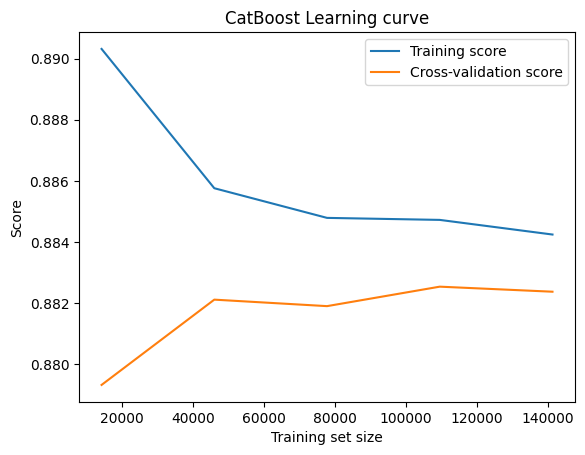

In [17]:
# Plot learning curve
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('CatBoost Learning curve')
plt.show()

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [20]:
cv_result = cross_validate(model, x_train, y_train, scoring=['f1', 'recall', 'accuracy', 'precision', 'neg_log_loss', 'balanced_accuracy'], cv=6, n_jobs=-1)
cv_result

{'fit_time': array([323.73797178, 321.45087695, 322.95067215, 322.76491308,
        318.65191531, 321.04690909]),
 'score_time': array([0.5936594 , 1.45432258, 0.74506783, 0.80206513, 2.60773277,
        1.71903014]),
 'test_f1': array([0.87253155, 0.87360581, 0.87593615, 0.87076784, 0.87833535,
        0.87266258]),
 'test_recall': array([0.83315237, 0.83626493, 0.83814694, 0.83408137, 0.83878674,
        0.83438292]),
 'test_accuracy': array([0.88107783, 0.88178507, 0.88401287, 0.87905792, 0.88648419,
        0.88103826]),
 'test_precision': array([0.91581795, 0.91443723, 0.91729383, 0.91083004, 0.92179793,
        0.9146235 ]),
 'test_neg_log_loss': array([-0.30315778, -0.3015199 , -0.30023166, -0.30494431, -0.29458788,
        -0.30338819]),
 'test_balanced_accuracy': array([0.88000262, 0.88076383, 0.88298387, 0.87804732, 0.88541245,
        0.87999309])}

In [19]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)


Accuracy: 0.8805093719487878
Precision: 0.9127458839489425
Recall: 0.8347855511378056
F1 score: 0.8720267463952752
